<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/ResNet50_VGGFace2_1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GravCont: ResNet50_VGGFace2**

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#ukiyoeから
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Random Seed:  1234
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#**モジュール群**

['cont', 'grav']
cont_train:296
grav_train:266
cont_val:74
grav_val:67
training data set_total：562
validating data set_total：141


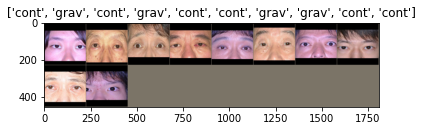

In [4]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Deep_learning/gravcont_seed_20200811'
n_samples = len(data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path=data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path=data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))



def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


    
    #Defining early stopping class
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
                scheduler.step()
                print('epoch:{}, lr:{}'.format(epoch, scheduler.get_last_lr()[0]))
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss


#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
  

#LRschedulerのバグ修正
#https://colab.research.google.com/drive/1idL-NPUvomAWzj_EVn2QccQVwQgEoGrJ

_LRScheduler = torch.optim.lr_scheduler._LRScheduler

class StepLR(_LRScheduler):
    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_last_lr(self):
        return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]


class MultiStepLR(_LRScheduler):
    def __init__(self, optimizer, milestones, gamma=0.1, last_epoch=-1):
        if not list(milestones) == sorted(milestones):
            raise ValueError('Milestones should be a list of'
                             ' increasing integers. Got {}', milestones)
        self.milestones = milestones
        self.gamma = gamma
        super(MultiStepLR, self).__init__(optimizer, last_epoch)

    def get_last_lr(self):
        return [base_lr * self.gamma ** bisect_right(self.milestones, self.last_epoch)
                for base_lr in self.base_lrs]

#**ネットワークの定義**

In [5]:
import torch
import torch.nn as nn


class Resnet50_ft_dag(nn.Module):

    def __init__(self):
        super(Resnet50_ft_dag, self).__init__()
        self.meta = {'mean': [131.0912, 103.8827, 91.4953],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=[7, 7], stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv1_relu_7x7_s2 = nn.ReLU()
        self.pool1_3x3_s2 = nn.MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
        self.conv2_1_1x1_reduce = nn.Conv2d(64, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_1x1_reduce_relu = nn.ReLU()
        self.conv2_1_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_1_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_3x3_relu = nn.ReLU()
        self.conv2_1_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_1x1_proj = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_proj_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_relu = nn.ReLU()
        self.conv2_2_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_1x1_reduce_relu = nn.ReLU()
        self.conv2_2_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_2_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_3x3_relu = nn.ReLU()
        self.conv2_2_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_relu = nn.ReLU()
        self.conv2_3_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_1x1_reduce_relu = nn.ReLU()
        self.conv2_3_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_3_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_3x3_relu = nn.ReLU()
        self.conv2_3_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_relu = nn.ReLU()
        self.conv3_1_1x1_reduce = nn.Conv2d(256, 128, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_1x1_reduce_relu = nn.ReLU()
        self.conv3_1_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_1_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_3x3_relu = nn.ReLU()
        self.conv3_1_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_1_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_1x1_proj = nn.Conv2d(256, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_proj_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_relu = nn.ReLU()
        self.conv3_2_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_1x1_reduce_relu = nn.ReLU()
        self.conv3_2_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_2_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_3x3_relu = nn.ReLU()
        self.conv3_2_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_relu = nn.ReLU()
        self.conv3_3_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_1x1_reduce_relu = nn.ReLU()
        self.conv3_3_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_3_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_3x3_relu = nn.ReLU()
        self.conv3_3_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_relu = nn.ReLU()
        self.conv3_4_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_1x1_reduce_relu = nn.ReLU()
        self.conv3_4_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_4_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_3x3_relu = nn.ReLU()
        self.conv3_4_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_relu = nn.ReLU()
        self.conv4_1_1x1_reduce = nn.Conv2d(512, 256, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_1x1_reduce_relu = nn.ReLU()
        self.conv4_1_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_1_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_3x3_relu = nn.ReLU()
        self.conv4_1_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_1_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_1x1_proj = nn.Conv2d(512, 1024, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_proj_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_relu = nn.ReLU()
        self.conv4_2_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_1x1_reduce_relu = nn.ReLU()
        self.conv4_2_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_2_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_3x3_relu = nn.ReLU()
        self.conv4_2_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_relu = nn.ReLU()
        self.conv4_3_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_1x1_reduce_relu = nn.ReLU()
        self.conv4_3_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_3_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_3x3_relu = nn.ReLU()
        self.conv4_3_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_relu = nn.ReLU()
        self.conv4_4_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_1x1_reduce_relu = nn.ReLU()
        self.conv4_4_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_4_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_3x3_relu = nn.ReLU()
        self.conv4_4_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_relu = nn.ReLU()
        self.conv4_5_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_1x1_reduce_relu = nn.ReLU()
        self.conv4_5_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_5_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_3x3_relu = nn.ReLU()
        self.conv4_5_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_relu = nn.ReLU()
        self.conv4_6_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_1x1_reduce_relu = nn.ReLU()
        self.conv4_6_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_6_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_3x3_relu = nn.ReLU()
        self.conv4_6_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_relu = nn.ReLU()
        self.conv5_1_1x1_reduce = nn.Conv2d(1024, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_1x1_reduce_relu = nn.ReLU()
        self.conv5_1_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_1_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_3x3_relu = nn.ReLU()
        self.conv5_1_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_1_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_1x1_proj = nn.Conv2d(1024, 2048, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_proj_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_relu = nn.ReLU()
        self.conv5_2_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_1x1_reduce_relu = nn.ReLU()
        self.conv5_2_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_2_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_3x3_relu = nn.ReLU()
        self.conv5_2_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_relu = nn.ReLU()
        self.conv5_3_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_1x1_reduce_relu = nn.ReLU()
        self.conv5_3_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_3_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_3x3_relu = nn.ReLU()
        self.conv5_3_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_relu = nn.ReLU()
        self.pool5_7x7_s1 = nn.AvgPool2d(kernel_size=[7, 7], stride=[1, 1], padding=0)
        self.classifier = nn.Conv2d(2048, 8631, kernel_size=[1, 1], stride=(1, 1))

    def forward(self, data):
        conv1_7x7_s2 = self.conv1_7x7_s2(data)
        conv1_7x7_s2_bn = self.conv1_7x7_s2_bn(conv1_7x7_s2)
        conv1_7x7_s2_bnxx = self.conv1_relu_7x7_s2(conv1_7x7_s2_bn)
        pool1_3x3_s2 = self.pool1_3x3_s2(conv1_7x7_s2_bnxx)
        conv2_1_1x1_reduce = self.conv2_1_1x1_reduce(pool1_3x3_s2)
        conv2_1_1x1_reduce_bn = self.conv2_1_1x1_reduce_bn(conv2_1_1x1_reduce)
        conv2_1_1x1_reduce_bnxx = self.conv2_1_1x1_reduce_relu(conv2_1_1x1_reduce_bn)
        conv2_1_3x3 = self.conv2_1_3x3(conv2_1_1x1_reduce_bnxx)
        conv2_1_3x3_bn = self.conv2_1_3x3_bn(conv2_1_3x3)
        conv2_1_3x3_bnxx = self.conv2_1_3x3_relu(conv2_1_3x3_bn)
        conv2_1_1x1_increase = self.conv2_1_1x1_increase(conv2_1_3x3_bnxx)
        conv2_1_1x1_increase_bn = self.conv2_1_1x1_increase_bn(conv2_1_1x1_increase)
        conv2_1_1x1_proj = self.conv2_1_1x1_proj(pool1_3x3_s2)
        conv2_1_1x1_proj_bn = self.conv2_1_1x1_proj_bn(conv2_1_1x1_proj)
        conv2_1 = torch.add(conv2_1_1x1_proj_bn, 1, conv2_1_1x1_increase_bn)
        conv2_1x = self.conv2_1_relu(conv2_1)
        conv2_2_1x1_reduce = self.conv2_2_1x1_reduce(conv2_1x)
        conv2_2_1x1_reduce_bn = self.conv2_2_1x1_reduce_bn(conv2_2_1x1_reduce)
        conv2_2_1x1_reduce_bnxx = self.conv2_2_1x1_reduce_relu(conv2_2_1x1_reduce_bn)
        conv2_2_3x3 = self.conv2_2_3x3(conv2_2_1x1_reduce_bnxx)
        conv2_2_3x3_bn = self.conv2_2_3x3_bn(conv2_2_3x3)
        conv2_2_3x3_bnxx = self.conv2_2_3x3_relu(conv2_2_3x3_bn)
        conv2_2_1x1_increase = self.conv2_2_1x1_increase(conv2_2_3x3_bnxx)
        conv2_2_1x1_increase_bn = self.conv2_2_1x1_increase_bn(conv2_2_1x1_increase)
        conv2_2 = torch.add(conv2_1x, 1, conv2_2_1x1_increase_bn)
        conv2_2x = self.conv2_2_relu(conv2_2)
        conv2_3_1x1_reduce = self.conv2_3_1x1_reduce(conv2_2x)
        conv2_3_1x1_reduce_bn = self.conv2_3_1x1_reduce_bn(conv2_3_1x1_reduce)
        conv2_3_1x1_reduce_bnxx = self.conv2_3_1x1_reduce_relu(conv2_3_1x1_reduce_bn)
        conv2_3_3x3 = self.conv2_3_3x3(conv2_3_1x1_reduce_bnxx)
        conv2_3_3x3_bn = self.conv2_3_3x3_bn(conv2_3_3x3)
        conv2_3_3x3_bnxx = self.conv2_3_3x3_relu(conv2_3_3x3_bn)
        conv2_3_1x1_increase = self.conv2_3_1x1_increase(conv2_3_3x3_bnxx)
        conv2_3_1x1_increase_bn = self.conv2_3_1x1_increase_bn(conv2_3_1x1_increase)
        conv2_3 = torch.add(conv2_2x, 1, conv2_3_1x1_increase_bn)
        conv2_3x = self.conv2_3_relu(conv2_3)
        conv3_1_1x1_reduce = self.conv3_1_1x1_reduce(conv2_3x)
        conv3_1_1x1_reduce_bn = self.conv3_1_1x1_reduce_bn(conv3_1_1x1_reduce)
        conv3_1_1x1_reduce_bnxx = self.conv3_1_1x1_reduce_relu(conv3_1_1x1_reduce_bn)
        conv3_1_3x3 = self.conv3_1_3x3(conv3_1_1x1_reduce_bnxx)
        conv3_1_3x3_bn = self.conv3_1_3x3_bn(conv3_1_3x3)
        conv3_1_3x3_bnxx = self.conv3_1_3x3_relu(conv3_1_3x3_bn)
        conv3_1_1x1_increase = self.conv3_1_1x1_increase(conv3_1_3x3_bnxx)
        conv3_1_1x1_increase_bn = self.conv3_1_1x1_increase_bn(conv3_1_1x1_increase)
        conv3_1_1x1_proj = self.conv3_1_1x1_proj(conv2_3x)
        conv3_1_1x1_proj_bn = self.conv3_1_1x1_proj_bn(conv3_1_1x1_proj)
        conv3_1 = torch.add(conv3_1_1x1_proj_bn, 1, conv3_1_1x1_increase_bn)
        conv3_1x = self.conv3_1_relu(conv3_1)
        conv3_2_1x1_reduce = self.conv3_2_1x1_reduce(conv3_1x)
        conv3_2_1x1_reduce_bn = self.conv3_2_1x1_reduce_bn(conv3_2_1x1_reduce)
        conv3_2_1x1_reduce_bnxx = self.conv3_2_1x1_reduce_relu(conv3_2_1x1_reduce_bn)
        conv3_2_3x3 = self.conv3_2_3x3(conv3_2_1x1_reduce_bnxx)
        conv3_2_3x3_bn = self.conv3_2_3x3_bn(conv3_2_3x3)
        conv3_2_3x3_bnxx = self.conv3_2_3x3_relu(conv3_2_3x3_bn)
        conv3_2_1x1_increase = self.conv3_2_1x1_increase(conv3_2_3x3_bnxx)
        conv3_2_1x1_increase_bn = self.conv3_2_1x1_increase_bn(conv3_2_1x1_increase)
        conv3_2 = torch.add(conv3_1x, 1, conv3_2_1x1_increase_bn)
        conv3_2x = self.conv3_2_relu(conv3_2)
        conv3_3_1x1_reduce = self.conv3_3_1x1_reduce(conv3_2x)
        conv3_3_1x1_reduce_bn = self.conv3_3_1x1_reduce_bn(conv3_3_1x1_reduce)
        conv3_3_1x1_reduce_bnxx = self.conv3_3_1x1_reduce_relu(conv3_3_1x1_reduce_bn)
        conv3_3_3x3 = self.conv3_3_3x3(conv3_3_1x1_reduce_bnxx)
        conv3_3_3x3_bn = self.conv3_3_3x3_bn(conv3_3_3x3)
        conv3_3_3x3_bnxx = self.conv3_3_3x3_relu(conv3_3_3x3_bn)
        conv3_3_1x1_increase = self.conv3_3_1x1_increase(conv3_3_3x3_bnxx)
        conv3_3_1x1_increase_bn = self.conv3_3_1x1_increase_bn(conv3_3_1x1_increase)
        conv3_3 = torch.add(conv3_2x, 1, conv3_3_1x1_increase_bn)
        conv3_3x = self.conv3_3_relu(conv3_3)
        conv3_4_1x1_reduce = self.conv3_4_1x1_reduce(conv3_3x)
        conv3_4_1x1_reduce_bn = self.conv3_4_1x1_reduce_bn(conv3_4_1x1_reduce)
        conv3_4_1x1_reduce_bnxx = self.conv3_4_1x1_reduce_relu(conv3_4_1x1_reduce_bn)
        conv3_4_3x3 = self.conv3_4_3x3(conv3_4_1x1_reduce_bnxx)
        conv3_4_3x3_bn = self.conv3_4_3x3_bn(conv3_4_3x3)
        conv3_4_3x3_bnxx = self.conv3_4_3x3_relu(conv3_4_3x3_bn)
        conv3_4_1x1_increase = self.conv3_4_1x1_increase(conv3_4_3x3_bnxx)
        conv3_4_1x1_increase_bn = self.conv3_4_1x1_increase_bn(conv3_4_1x1_increase)
        conv3_4 = torch.add(conv3_3x, 1, conv3_4_1x1_increase_bn)
        conv3_4x = self.conv3_4_relu(conv3_4)
        conv4_1_1x1_reduce = self.conv4_1_1x1_reduce(conv3_4x)
        conv4_1_1x1_reduce_bn = self.conv4_1_1x1_reduce_bn(conv4_1_1x1_reduce)
        conv4_1_1x1_reduce_bnxx = self.conv4_1_1x1_reduce_relu(conv4_1_1x1_reduce_bn)
        conv4_1_3x3 = self.conv4_1_3x3(conv4_1_1x1_reduce_bnxx)
        conv4_1_3x3_bn = self.conv4_1_3x3_bn(conv4_1_3x3)
        conv4_1_3x3_bnxx = self.conv4_1_3x3_relu(conv4_1_3x3_bn)
        conv4_1_1x1_increase = self.conv4_1_1x1_increase(conv4_1_3x3_bnxx)
        conv4_1_1x1_increase_bn = self.conv4_1_1x1_increase_bn(conv4_1_1x1_increase)
        conv4_1_1x1_proj = self.conv4_1_1x1_proj(conv3_4x)
        conv4_1_1x1_proj_bn = self.conv4_1_1x1_proj_bn(conv4_1_1x1_proj)
        conv4_1 = torch.add(conv4_1_1x1_proj_bn, 1, conv4_1_1x1_increase_bn)
        conv4_1x = self.conv4_1_relu(conv4_1)
        conv4_2_1x1_reduce = self.conv4_2_1x1_reduce(conv4_1x)
        conv4_2_1x1_reduce_bn = self.conv4_2_1x1_reduce_bn(conv4_2_1x1_reduce)
        conv4_2_1x1_reduce_bnxx = self.conv4_2_1x1_reduce_relu(conv4_2_1x1_reduce_bn)
        conv4_2_3x3 = self.conv4_2_3x3(conv4_2_1x1_reduce_bnxx)
        conv4_2_3x3_bn = self.conv4_2_3x3_bn(conv4_2_3x3)
        conv4_2_3x3_bnxx = self.conv4_2_3x3_relu(conv4_2_3x3_bn)
        conv4_2_1x1_increase = self.conv4_2_1x1_increase(conv4_2_3x3_bnxx)
        conv4_2_1x1_increase_bn = self.conv4_2_1x1_increase_bn(conv4_2_1x1_increase)
        conv4_2 = torch.add(conv4_1x, 1, conv4_2_1x1_increase_bn)
        conv4_2x = self.conv4_2_relu(conv4_2)
        conv4_3_1x1_reduce = self.conv4_3_1x1_reduce(conv4_2x)
        conv4_3_1x1_reduce_bn = self.conv4_3_1x1_reduce_bn(conv4_3_1x1_reduce)
        conv4_3_1x1_reduce_bnxx = self.conv4_3_1x1_reduce_relu(conv4_3_1x1_reduce_bn)
        conv4_3_3x3 = self.conv4_3_3x3(conv4_3_1x1_reduce_bnxx)
        conv4_3_3x3_bn = self.conv4_3_3x3_bn(conv4_3_3x3)
        conv4_3_3x3_bnxx = self.conv4_3_3x3_relu(conv4_3_3x3_bn)
        conv4_3_1x1_increase = self.conv4_3_1x1_increase(conv4_3_3x3_bnxx)
        conv4_3_1x1_increase_bn = self.conv4_3_1x1_increase_bn(conv4_3_1x1_increase)
        conv4_3 = torch.add(conv4_2x, 1, conv4_3_1x1_increase_bn)
        conv4_3x = self.conv4_3_relu(conv4_3)
        conv4_4_1x1_reduce = self.conv4_4_1x1_reduce(conv4_3x)
        conv4_4_1x1_reduce_bn = self.conv4_4_1x1_reduce_bn(conv4_4_1x1_reduce)
        conv4_4_1x1_reduce_bnxx = self.conv4_4_1x1_reduce_relu(conv4_4_1x1_reduce_bn)
        conv4_4_3x3 = self.conv4_4_3x3(conv4_4_1x1_reduce_bnxx)
        conv4_4_3x3_bn = self.conv4_4_3x3_bn(conv4_4_3x3)
        conv4_4_3x3_bnxx = self.conv4_4_3x3_relu(conv4_4_3x3_bn)
        conv4_4_1x1_increase = self.conv4_4_1x1_increase(conv4_4_3x3_bnxx)
        conv4_4_1x1_increase_bn = self.conv4_4_1x1_increase_bn(conv4_4_1x1_increase)
        conv4_4 = torch.add(conv4_3x, 1, conv4_4_1x1_increase_bn)
        conv4_4x = self.conv4_4_relu(conv4_4)
        conv4_5_1x1_reduce = self.conv4_5_1x1_reduce(conv4_4x)
        conv4_5_1x1_reduce_bn = self.conv4_5_1x1_reduce_bn(conv4_5_1x1_reduce)
        conv4_5_1x1_reduce_bnxx = self.conv4_5_1x1_reduce_relu(conv4_5_1x1_reduce_bn)
        conv4_5_3x3 = self.conv4_5_3x3(conv4_5_1x1_reduce_bnxx)
        conv4_5_3x3_bn = self.conv4_5_3x3_bn(conv4_5_3x3)
        conv4_5_3x3_bnxx = self.conv4_5_3x3_relu(conv4_5_3x3_bn)
        conv4_5_1x1_increase = self.conv4_5_1x1_increase(conv4_5_3x3_bnxx)
        conv4_5_1x1_increase_bn = self.conv4_5_1x1_increase_bn(conv4_5_1x1_increase)
        conv4_5 = torch.add(conv4_4x, 1, conv4_5_1x1_increase_bn)
        conv4_5x = self.conv4_5_relu(conv4_5)
        conv4_6_1x1_reduce = self.conv4_6_1x1_reduce(conv4_5x)
        conv4_6_1x1_reduce_bn = self.conv4_6_1x1_reduce_bn(conv4_6_1x1_reduce)
        conv4_6_1x1_reduce_bnxx = self.conv4_6_1x1_reduce_relu(conv4_6_1x1_reduce_bn)
        conv4_6_3x3 = self.conv4_6_3x3(conv4_6_1x1_reduce_bnxx)
        conv4_6_3x3_bn = self.conv4_6_3x3_bn(conv4_6_3x3)
        conv4_6_3x3_bnxx = self.conv4_6_3x3_relu(conv4_6_3x3_bn)
        conv4_6_1x1_increase = self.conv4_6_1x1_increase(conv4_6_3x3_bnxx)
        conv4_6_1x1_increase_bn = self.conv4_6_1x1_increase_bn(conv4_6_1x1_increase)
        conv4_6 = torch.add(conv4_5x, 1, conv4_6_1x1_increase_bn)
        conv4_6x = self.conv4_6_relu(conv4_6)
        conv5_1_1x1_reduce = self.conv5_1_1x1_reduce(conv4_6x)
        conv5_1_1x1_reduce_bn = self.conv5_1_1x1_reduce_bn(conv5_1_1x1_reduce)
        conv5_1_1x1_reduce_bnxx = self.conv5_1_1x1_reduce_relu(conv5_1_1x1_reduce_bn)
        conv5_1_3x3 = self.conv5_1_3x3(conv5_1_1x1_reduce_bnxx)
        conv5_1_3x3_bn = self.conv5_1_3x3_bn(conv5_1_3x3)
        conv5_1_3x3_bnxx = self.conv5_1_3x3_relu(conv5_1_3x3_bn)
        conv5_1_1x1_increase = self.conv5_1_1x1_increase(conv5_1_3x3_bnxx)
        conv5_1_1x1_increase_bn = self.conv5_1_1x1_increase_bn(conv5_1_1x1_increase)
        conv5_1_1x1_proj = self.conv5_1_1x1_proj(conv4_6x)
        conv5_1_1x1_proj_bn = self.conv5_1_1x1_proj_bn(conv5_1_1x1_proj)
        conv5_1 = torch.add(conv5_1_1x1_proj_bn, 1, conv5_1_1x1_increase_bn)
        conv5_1x = self.conv5_1_relu(conv5_1)
        conv5_2_1x1_reduce = self.conv5_2_1x1_reduce(conv5_1x)
        conv5_2_1x1_reduce_bn = self.conv5_2_1x1_reduce_bn(conv5_2_1x1_reduce)
        conv5_2_1x1_reduce_bnxx = self.conv5_2_1x1_reduce_relu(conv5_2_1x1_reduce_bn)
        conv5_2_3x3 = self.conv5_2_3x3(conv5_2_1x1_reduce_bnxx)
        conv5_2_3x3_bn = self.conv5_2_3x3_bn(conv5_2_3x3)
        conv5_2_3x3_bnxx = self.conv5_2_3x3_relu(conv5_2_3x3_bn)
        conv5_2_1x1_increase = self.conv5_2_1x1_increase(conv5_2_3x3_bnxx)
        conv5_2_1x1_increase_bn = self.conv5_2_1x1_increase_bn(conv5_2_1x1_increase)
        conv5_2 = torch.add(conv5_1x, 1, conv5_2_1x1_increase_bn)
        conv5_2x = self.conv5_2_relu(conv5_2)
        conv5_3_1x1_reduce = self.conv5_3_1x1_reduce(conv5_2x)
        conv5_3_1x1_reduce_bn = self.conv5_3_1x1_reduce_bn(conv5_3_1x1_reduce)
        conv5_3_1x1_reduce_bnxx = self.conv5_3_1x1_reduce_relu(conv5_3_1x1_reduce_bn)
        conv5_3_3x3 = self.conv5_3_3x3(conv5_3_1x1_reduce_bnxx)
        conv5_3_3x3_bn = self.conv5_3_3x3_bn(conv5_3_3x3)
        conv5_3_3x3_bnxx = self.conv5_3_3x3_relu(conv5_3_3x3_bn)
        conv5_3_1x1_increase = self.conv5_3_1x1_increase(conv5_3_3x3_bnxx)
        conv5_3_1x1_increase_bn = self.conv5_3_1x1_increase_bn(conv5_3_1x1_increase)
        conv5_3 = torch.add(conv5_2x, 1, conv5_3_1x1_increase_bn)
        conv5_3x = self.conv5_3_relu(conv5_3)
        pool5_7x7_s1 = self.pool5_7x7_s1(conv5_3x)
        classifier_preflatten = self.classifier(pool5_7x7_s1)
        classifier = classifier_preflatten.view(classifier_preflatten.size(0), -1)
        #return classifier, pool5_7x7_s1 　出力を変更しておかないと次元が合わないと言われる
        return classifier

def resnet50_ft_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Resnet50_ft_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [6]:
#Pretrained dataと結びつける
model_ft = Resnet50_ft_dag()
model_ft.load_state_dict(torch.load('/content/drive/My Drive/Deep_learning/resnet50_ft_dag.pth'))

<All keys matched successfully>

#**モデルの訓練**

In [7]:
import torch.nn as nn

#最終結合層のリセットと付け替え(全結合層を2つに)
#model_ft.classifier = nn.Conv2d(2048, len(class_names), kernel_size=[1,1], stride=(1,1), bias = False)
model_ft.classifier = nn.Linear(2048, 2)
model_ft.classifier = nn.Sequential(*([Flatten()] + list(model_ft.children())[-1:])) #Flattenを挿入

#ネットワークの確認
from torchsummary import summary
model_ft = model_ft.to(device)
summary(model_ft, (3,224,224))

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:186: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


In [8]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=100)

Epoch 0/99
----------
epoch:0, lr:0.001
train Loss: 2.0108 Acc: 0.5587
val Loss: 3.9253 Acc: 0.5177
Validation loss decreased (inf --> 3.925323).  Saving model ...

Epoch 1/99
----------
epoch:1, lr:0.001
train Loss: 1.1667 Acc: 0.6281
val Loss: 3.3062 Acc: 0.6241
Validation loss decreased (3.925323 --> 3.306193).  Saving model ...

Epoch 2/99
----------
epoch:2, lr:0.001
train Loss: 0.5488 Acc: 0.7456
val Loss: 0.5275 Acc: 0.7376
Validation loss decreased (3.306193 --> 0.527539).  Saving model ...

Epoch 3/99
----------
epoch:3, lr:0.001
train Loss: 0.4919 Acc: 0.7900
val Loss: 0.4412 Acc: 0.7801
Validation loss decreased (0.527539 --> 0.441173).  Saving model ...

Epoch 4/99
----------
epoch:4, lr:0.001
train Loss: 0.4361 Acc: 0.8007
val Loss: 0.4712 Acc: 0.7589
EarlyStopping counter: 1 out of 5

Epoch 5/99
----------
epoch:5, lr:0.001
train Loss: 0.4274 Acc: 0.8203
val Loss: 0.5434 Acc: 0.6879
EarlyStopping counter: 2 out of 5

Epoch 6/99
----------
epoch:6, lr:0.0001
train Loss: 0.

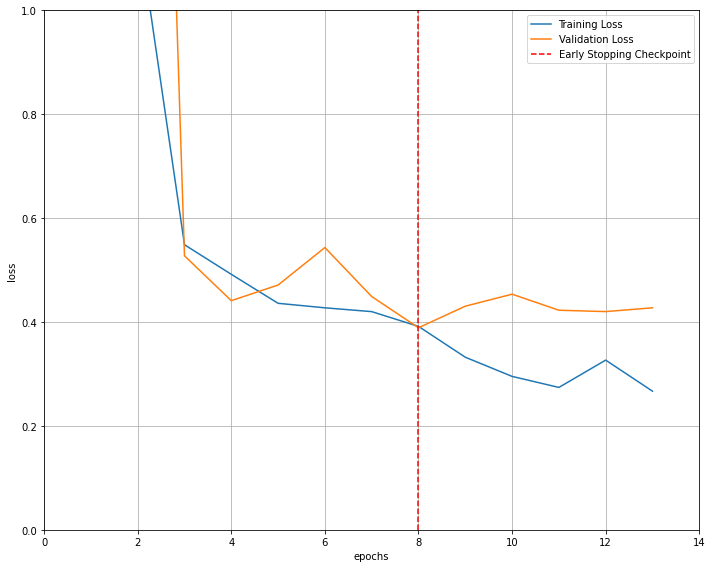

In [11]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Calculating accuracy**

In [12]:
#Calculating accuracy

#valフォルダ内のファイル名を取得
image_path = glob.glob(data_dir +"/val/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print('number of images: ' +str(len(image_path)))
#print(image_path) 



"""
#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)
"""

#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #model_pred:クラス名前、prob:確率、pred:クラス番号
    prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
    model_pred = class_names[pred]
    
    #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
    prob = abs(1-float(prob)-float(pred))
 
    return model_pred, prob, pred

    """
    #probalilityを計算する
    pred_prob = torch.topk(nn.Softmax(dim=1)(output), 1)[0]
    pred_class = torch.topk(nn.Softmax(dim=1)(output), 1)[1]
    if pred_class == 1:
        pred_prob = pred_prob
    elif pred_class == 0:
        pred_prob = 1- pred_prob
    return(model_pred, pred_prob)  #class_nameの番号で出力される
    """

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    return(accuracy, precision, recall, specificity, f_value)


#ここからがメイン
TP, FP, TN, FN, TP, FP, TN, FN = [0,0,0,0,0,0,0,0]
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []

model_pred_class = []
model_pred_prob = []


for i in image_path:
      image_name, label = getlabel(i)  #画像の名前とラベルを取得
      image_tensor = image_transform(i)  #予測のための画像下処理
      model_pred, prob, pred = image_eval(image_tensor, label)  #予測結果を出力   
      #print('Image: '+ image_name)
      #print('Label: '+ label)
      #print('Pred: '+ model_pred)
      #showImage(i)  #画像を表示
      #print() #空白行を入れる
      time.sleep(0.1)

      image_name_list.append(image_name)
      label_list.append(label)
      model_pred_list.append(model_pred)

      model_pred_class.append(int(pred))
      model_pred_prob.append(float(prob))

      if label == class_names[0]:
          if model_pred == class_names[0]:
              TN += 1
          else:
              FP += 1
      elif label == class_names[1]:
          if model_pred == class_names[1]:
              TP += 1
          else:
              FN += 1
      

print(TP, FN, TN, FP)

#Accuracyを計算
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP, TN, FP, FN)
print('Accuracy: ' + str(accuracy))
print('Precision (positive predictive value): ' + str(precision))
print('Recall (sensitivity): ' + str(recall))
print('Specificity: ' + str(specificity))
print('F_value: ' + str(f_value))

print(model_pred_class)
print(model_pred_prob)

number of images: 141
52 15 67 7
Accuracy: 0.8439716312056738
Precision (positive predictive value): 0.8813559322033898
Recall (sensitivity): 0.7761194029850746
Specificity: 0.9054054054054054
F_value: 0.8253968253968255
[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0.9960483908653259, 0.329093337059021, 0.05767250061035156, 0.10017168521881104, 0.8490554690361023, 0.4453698396682739, 0.927548348903656, 0.16120874881744385, 0.2532351016998291, 0.9912153482437134, 0.7253419160842896, 0.04346960783004761, 0.07098227739334106, 0.11683660745620728, 0.9603606462478638, 0.11855751276016235, 0.10559630393981934, 0.618522

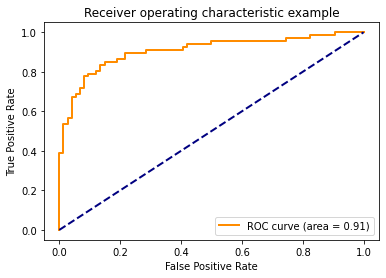

In [13]:
#ROC curve

import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = []
y_true = []

k=0
for i in label_list:
    if label_list[k] == 'cont':
          y_true.append(0)
    elif label_list[k] == 'grav':
          y_true.append(1)
    k+=1


#健康な状態を「0」、病気を「1」としてラベルよりリストを作成
y_true = y_true
#それぞれの画像における陽性の確率についてリストを作成
y_score = model_pred_prob

#print(y_true)
#print(y_score)

fpr, tpr,thred = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

#print(fpr)
#print(tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#重みセーブ
PATH = '/content/drive/My Drive/Deep_learning/GravCont_Resnet50_VGGFace2_seed_'+str(manualSeed)+'.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
#重みロード
PATH = '/content/drive/My Drive/Deep_learning/GravCont_Resnet50_VGGFace2_seed_'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>